In [ ]:
# This is the notebook accompanying the coherent score statistic
# marginalized over the higher mode amplitudes as
# introduced in the papers arXiv: 2405.17400 and 2404.02435
# This notebook uses the code cogwheel
# For any ambiguity or if you need any more info, please contact 
# jayw@ias.edu or jroulet@caltech.edu

In [1]:
# Change to your directory which has the data files
dire = "/Users/jayw/Downloads/"

In [2]:
import os, sys
# sys.path.insert(0,"/data/jayw/IAS/GW/gw_detection_ias") # or use dire
os.chdir(dire)
# Download coherent_score_hm_search.py and add it to the directory
import coherent_score_hm_search as cs
# This needs cogwheel to be installed: https://github.com/jroulet/cogwheel
#  conda install -c conda-forge cogwheel-pe

import numpy as np
import matplotlib.pyplot as plt

/Users/jayw/miniconda3/envs/gw/lib/python3.10/site-packages/cogwheel/waveform.py:6: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [3]:
# Loading data from the IAS search pipeline for one of the GW events: GW190711_030756
# In case you want to generate the timeseries yourself for a different event,
# you could use the following tutorial from cogwheel:
# https://github.com/jroulet/cogwheel/blob/main/tutorials/extrinsic_marginalization.ipynb
inputs = np.load(dire+'/SNR_Timeseries_GW190711.npz')

# <data|model_waveform> with 3 dims: [mode, times, detectors] (Eq. 9)
dh_mtd = inputs['dh_mtd'];
# <model_waveform|model_waveform> with 3 dims: [mode, detectors] 
# (basically covariance matrix of the unorthogonalized modes) (Eq. 8)
hh_md=inputs['hh_md'];
# array of times
times = inputs['times'];
# sum of SNR^2 of modes (after orthogonalization of modes)
incoherent_lnprob_td=inputs['incoherent_lnprob_td'];

# R33, R44 values given in the Eq. 7
# In a future paper, we will release a code to calculate R33, R44
# for any arbitrary event
mode_ratios_qm=inputs['mode_ratios_qm'];
# array with time of H and L trigger
trigger_times=inputs['trigger_times']

In [4]:
detectors=('H1', 'L1')

# Hyperparameters for cogwheel marginalization integral
LOG2N_QMC, NPHI, MAX_LOG2N_QMC, MIN_N_EFFECTIVE = 12, 256, 16, 50

# Create a coherent score instance
cs_instance = cs.SearchCoherentScoreHMAS(
        sky_dict=cs.cogwheel.likelihood.marginalization.SkyDictionary(
                detectors[0][0]+detectors[1][0]),
        log2n_qmc=LOG2N_QMC, nphi=NPHI,
        max_log2n_qmc=MAX_LOG2N_QMC, n_qmc_sequences=100, seed=None)
cs_instance.min_n_effective = MIN_N_EFFECTIVE

# Create 100 different initial QMC sequences for marginalization integral
# (later, samples from each will be combined to give a better sampled posterior)
for i in range(len(cs_instance._qmc_sequences)):
    cs_instance._rng.random()
    cs_instance._qmc_sequences[i] = cs_instance._create_qmc_sequence()

# Calculating reference distance to SNR=1 template and rescaling
dist_factor_ref = cs_instance.lookup_table.d_luminosity_max\
                    /cs_instance.lookup_table.REFERENCE_DISTANCE

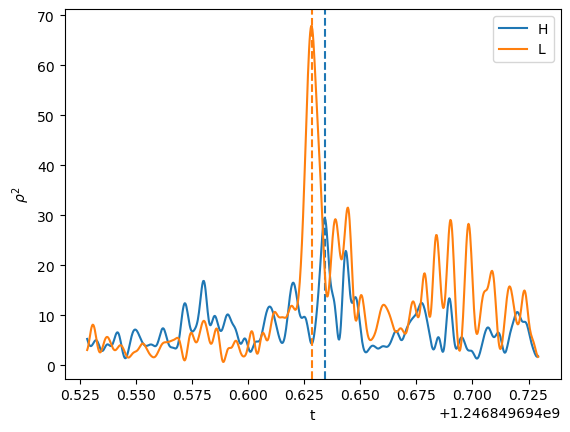

In [5]:
plt.figure()
plt.plot(times, 2*incoherent_lnprob_td[:,0], label='H'); plt.axvline(x=trigger_times[0], c='C0', ls='--')
plt.plot(times, 2*incoherent_lnprob_td[:,1],label='L'); plt.axvline(x=trigger_times[1], c='C1', ls='--')
# plt.axhline(y = np.max(2*incoherent_lnprob_td[:,1])-10)
plt.xlabel('t'); plt.ylabel(r'$\rho^2$'); plt.legend();

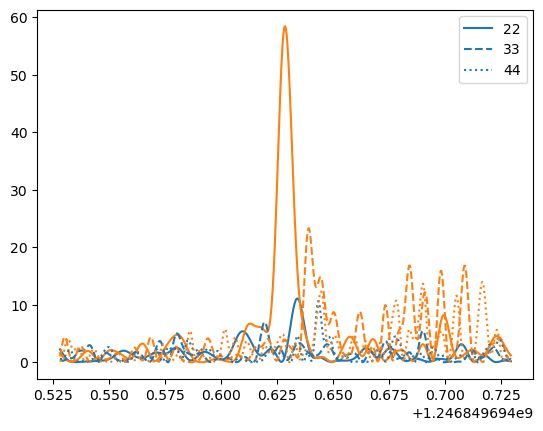

In [6]:
dh_mtd[:,:,0] /= dist_factor_ref
dh_mtd[:,:,1] /= dist_factor_ref
plt.plot(times,np.abs(dh_mtd[0])**2, label=['22',''])
plt.plot(times, (np.abs(dh_mtd[1])**2)[:,0], ls='--', color='C0', label='33')
plt.plot(times, (np.abs(dh_mtd[1])**2)[:,1], ls='--', color='C1')
plt.plot(times, (np.abs(dh_mtd[2])**2)[:,0], ls='dotted', color='C0', label='44')
plt.plot(times, (np.abs(dh_mtd[2])**2)[:,1], ls='dotted', color='C1')
plt.legend()
dh_mtd[:,:,0] *= dist_factor_ref
dh_mtd[:,:,1] *= dist_factor_ref
# plt.xlim(left=times[350], right=times[480])

# Again, blue is H, orange is L

In [7]:
# Generating samples from the marginalized integral

import pandas as pd
from cogwheel import gw_plotting
def _gen_samples_from_marg_info(self, marg_info, num): 
    """
    Generate requested number of extrinsic parameter samples.

    Parameters
    ----------
    marg_info: MarginalizationInfoHM
        Output of ``.get_marginalization_info``.

    num: int, optional
        Number of samples to generate, defaults to a single sample.

    Return
    ------
    samples: dict
        Values are scalar if `num` is ``None``, else numpy arrays.
        If ``marg_info`` correspond to an unphysical sample (i.e.,
        a realization of matched-filtering timeseries in the
        detectors incompatible with a real signal) the values will
        be NaN.
    """
    if marg_info.q_inds.size == 0:
        return dict.fromkeys(['d_luminosity', 'dec', 'lon', 'phi_ref',
                              'psi', 't_geocenter', 'lnl_marginalized',
                              'lnl', 'h_h', 'n_effective', 'n_qmc'],
                             np.full(num, np.nan)[()])

    random_ids = self._rng.choice(len(marg_info.q_inds), size=num,
                                  p=marg_info.weights)

    q_ids = marg_info.q_inds[random_ids]
    o_ids = marg_info.o_inds[random_ids]
    sky_ids = marg_info.sky_inds[random_ids]
    t_geocenter = (marg_info.t_first_det[random_ids]
                   - self.sky_dict.geocenter_delay_first_det[sky_ids])
    d_h = marg_info.d_h[random_ids]
    h_h = marg_info.h_h[random_ids]

    d_luminosity = self._sample_distance(d_h, h_h)
    distance_ratio = d_luminosity / self.lookup_table.REFERENCE_DISTANCE
    return {
        'd_luminosity': d_luminosity,
        'dec': self.sky_dict.sky_samples['lat'][sky_ids],
        'lon': self.sky_dict.sky_samples['lon'][sky_ids],
        'phi_ref': self._phi_ref[o_ids],
        'psi': self._qmc_sequence['psi'][q_ids],
        't_geocenter': t_geocenter,
        'lnl_marginalized': np.full(num, marg_info.lnl_marginalized)[()],
        'lnl': d_h / distance_ratio - h_h / distance_ratio**2 / 2,
        'h_h': h_h / distance_ratio**2,
        'n_effective': np.full(num, marg_info.n_effective)[()],
        'n_qmc': np.full(num, marg_info.n_qmc)[()],
        'cosiota': self._qmc_sequence['cosiota'][q_ids],
        }

In [8]:
# Making samples for 22+HM case
samples_list = []
for i in range(100):
    marg_info = cs_instance.get_marginalization_info(dh_mtd, hh_md,
                            times, incoherent_lnprob_td, mode_ratios_qm)
    samples_list.append(pd.DataFrame(_gen_samples_from_marg_info(cs_instance, marg_info, 100)))
samples = pd.concat(samples_list)
samples = pd.DataFrame(samples)

In [9]:
# Making samples for 22-only case by multiplying mode ratio prior by zero
samples_list = []
for i in range(100):
    marg_info = cs_instance.get_marginalization_info(dh_mtd, hh_md,
                            times, incoherent_lnprob_td, mode_ratios_qm*0)
    samples_list.append(pd.DataFrame(_gen_samples_from_marg_info(cs_instance, marg_info, 100)))
samples_QAS = pd.concat(samples_list)
samples_QAS = pd.DataFrame(samples_QAS)

In [10]:
params_samples = ['lon','dec',
 'd_luminosity',
 # 'psi',
 # 't_H','t_L', 'h_h','n_effective','lnl_marginalized',
'cosiota',
 'lnl']

# Currently d_luminosity is in normlized units (SNR=1 at 15 Gpc)
# To convert to physical units, multiply by the reference distance
# We will automate this in a future paper

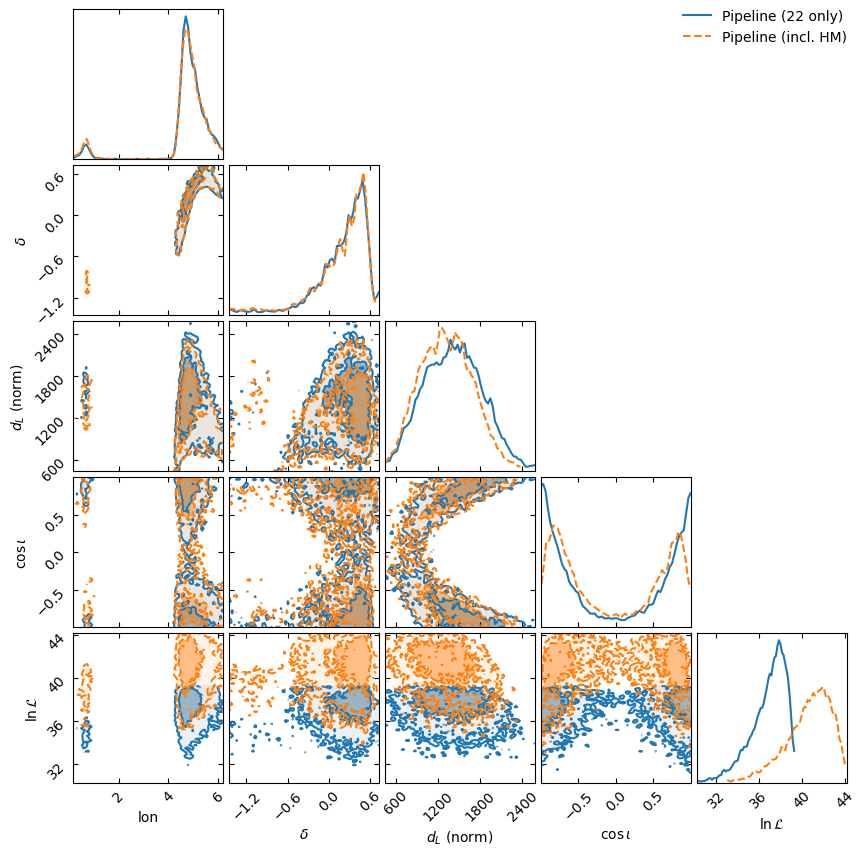

In [12]:
cp = gw_plotting.MultiCornerPlot((samples_QAS[params_samples],samples[params_samples]), tail_probability=1e-2,
                                  bins=64, labels=['Pipeline (22 only)','Pipeline (incl. HM)'])
cp.corner_plots[0].latex_labels.units['d_luminosity'] = 'norm'
cp.plot()

# To ensure that these give roughly unbiased results,
# we plan to compare these with a full PE run in a future paper

In [13]:
# Just for reference, the coherent score that we use as part of the ranking statistic
# in our search is calculated as:
cs_instance.lnlike_marginalized(dh_mtd, hh_md,
                    times, incoherent_lnprob_td, mode_ratios_qm)

19.66888536485819